In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!mount --bind /content/drive/My\ Drive /content/MyDrive

mount: /content/MyDrive: mount point does not exist.


In [3]:
import os
os.getcwd()
!mkdir MyDrive

In [4]:
!mount --bind /content/drive/My\ Drive /content/MyDrive

In [5]:
import numpy as np
import random
from numpy.random import seed
from numpy.random import normal
from math import floor, ceil
from random import randint
from random import shuffle
import statistics
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from scipy import integrate
import pandas as pd
import itertools

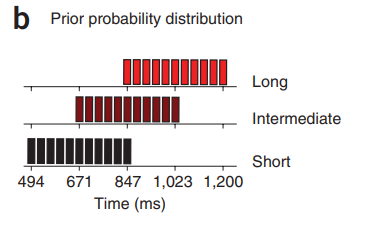

In [6]:
small = np.linspace(494, 847, 11) # small interval
intermediate = np.linspace(671, 1023, 11) # intermediate interval
large = np.linspace(847, 1200, 11) # large interval

sample_size = 300
print(small)
print(intermediate)
print(large)

[494.  529.3 564.6 599.9 635.2 670.5 705.8 741.1 776.4 811.7 847. ]
[ 671.   706.2  741.4  776.6  811.8  847.   882.2  917.4  952.6  987.8
 1023. ]
[ 847.   882.3  917.6  952.9  988.2 1023.5 1058.8 1094.1 1129.4 1164.7
 1200. ]


In [7]:
def sampleGeneration(range_, small):
  # lets generate ts data:
  random.seed(1)
  seqs = [small]

  t_s = []
  for i in range(range_):
    x = random.choice(random.choices(seqs, weights=map(len, seqs))[0])
    t_s.append(round(x))
    ran_value = random.choice(t_s)
    #print(ran_value)
    #print("Our generated t_s list with 50 sample points: ", t_s)
    #print(min(t_s))
    #print(max(t_s))
  return t_s, min(t_s), max(t_s)

t_s_small, t_s_small_min, t_s_small_max = sampleGeneration(sample_size, small)
t_s_medium, t_s_medium_min, t_s_medium_max = sampleGeneration(sample_size, intermediate)
t_s_large, t_s_large_min, t_s_large_max = sampleGeneration(sample_size, large)

In [8]:
# introduce scalar property through noise by introducing k
# Note that: t_m, t_s, t_e, t_p are lists
#            tm, ts, te, tp are elements in those lists

# Lets set k = 64, 128, 256

def measurementGeneration(t_s, k):
  t_m = []
  for ts in t_s:
    value = np.random.normal(-k/2,k/2)
    b = ts + np.random.choice([1,-1])*value
    t_m.append((round(b, 2)))
    #print("Our measured t_m list with 50 values: ", t_m)
  avg = round(statistics.mean(t_m), 2)
  std = round(statistics.stdev(t_m), 2)
  wm = round(std/avg, 2)  # coefficient of variation
  #print(avg, std, wm)
  return t_m, avg, std, wm

In [9]:
t_m_small, avg_small, std_small, wm_small = measurementGeneration(t_s_small, 64)
t_m_medium, avg_medium, std_medium, wm_medium = measurementGeneration(t_s_medium, 128)
t_m_large, avg_large, std_large, wm_large = measurementGeneration(t_s_large, 256)

Noise distribution associated with the measurement stage.

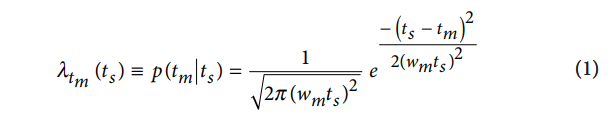


In [10]:
# define a function to capture the measurement noise distribution

def measurement_noise(ts, tm, wm):
  return (1 / math.sqrt(2 * math.pi * ((wm*ts) **2))) * math.exp(-((ts - tm) ** 2) / (2 * ((wm*ts) ** 2)))

Noise distribution associated with the production stage.

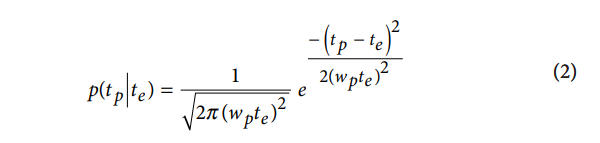

In [11]:
# define a function to capture the production noise distribution

def production_noise(tp, te, wp):
  return (1 / math.sqrt(2 * math.pi * ((wp*te) **2))) * math.exp(-((tp - te) ** 2) / (2 * ((wp*te) ** 2)))
  
def measurement_noise_ts(ts, tm, wm):
  return (ts / math.sqrt(2 * math.pi * ((wm*ts) **2))) * math.exp(-((ts - tm) ** 2) / (2 * ((wm*ts) ** 2)))

Uniform distribution is given by;

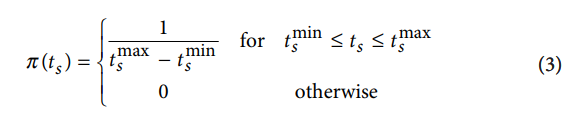

In [12]:
# discrete uniform prior distribution as continuos..
def uniformDistribution(t_s):
  return 1/(max(t_s) - min(t_s))

pi_ts_small = uniformDistribution(t_s_small)
pi_ts_medium = uniformDistribution(t_s_medium)
pi_ts_large = uniformDistribution(t_s_large)

The posterior is the product of prior multiplied by the likelihood and normalized.

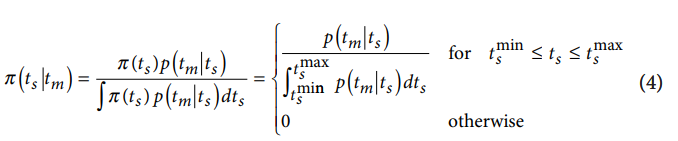

In [13]:
def posterior(t_s, t_m, wm, small, sample_size):

    x = np.linspace(min(small), max(small), sample_size)
    # measurement_noise vector
    P_tm_ts = []
    for ts, tm in zip(t_s, t_m):
      _noise =  measurement_noise(ts, tm, wm)
      P_tm_ts.append(_noise)

    integrate_P_tm_ts = integrate.simps(P_tm_ts, x)
    P_tm_ts = np.array(P_tm_ts)

    # posterior probability is; 
    pi_ts_tm = P_tm_ts/integrate_P_tm_ts
    
    return pi_ts_tm


pi_ts_tm_small = posterior(t_s_small, t_m_small, wm_small, small, sample_size)
pi_ts_tm_medium = posterior(t_s_medium, t_m_medium, wm_medium, intermediate, sample_size)
pi_ts_tm_large = posterior(t_s_large, t_m_large, wm_large, large, sample_size)

The estimator function.

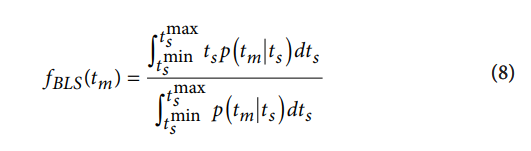

In [14]:

def estimator(t_m, t_s, wm, small, sample_size):
    t_m = np.array(t_m)
    t_s = np.array(t_s)

    t_e  = [] # for estimator 
    x = np.linspace(min(small), max(small), sample_size)

    for tm in t_m:
      upper_array = []
      lower_array = []
      for ts in t_s:
        upper = measurement_noise_ts(ts, tm, wm)
        lower = measurement_noise(ts, tm, wm)

        upper_array.append(upper)
        lower_array.append(lower)

      integrate_te_numerator = integrate.simps(upper_array, x)
      integrate_te_denominator = integrate.simps(lower_array, x)

      # Bayesian Least square estimator is;
      f_BLS = integrate_te_numerator/integrate_te_denominator

      t_e.append(f_BLS)

    return t_e
t_e_small = estimator(t_m_small, t_s_small, wm_small, small, sample_size)
t_e_medium = estimator(t_m_medium, t_s_medium, wm_medium, intermediate, sample_size)
t_e_large = estimator(t_m_large, t_s_large, wm_large, large, sample_size)

t_e_small = np.array(t_e_small)
t_e_medium = np.array(t_e_medium)
t_e_large = np.array(t_e_large)

In [15]:
def dictionary(t_s, t_e):
  dict_ = {}

  for ts, te in zip(t_s, t_e):
    if ts not in dict_.keys():
      dict_[ts] = []
      dict_[ts].append(te)


    if ts in dict_.keys():
      dict_[ts].append(te)

  sort_data = sorted(dict_.items(), key=lambda x: x[0])
  sort_data_dict = dict(sort_data)
  return sort_data_dict

sort_data_dict_small = dictionary(t_s_small, t_e_small)
sort_data_dict_medium = dictionary(t_s_medium, t_e_medium)
sort_data_dict_large = dictionary(t_s_large, t_e_large)

In [16]:
def plotFunction(sort_data_dict_small):
  
  xs, ys = [], []
  xs_, ys_ = [], []

  for k, v in sort_data_dict_small.items():  
    avg = statistics.mean(v)
    xs.extend(list(itertools.repeat(k, len(v))))
    ys.extend(v)
    ys_.append(avg)
    xs_.append(k)

  return xs, ys, xs_, ys_

In [17]:
xs, ys, xs_, ys_ = plotFunction(sort_data_dict_small)
xm, ym, xm_, ym_ = plotFunction(sort_data_dict_medium)
xl, yl, xl_, yl_ = plotFunction(sort_data_dict_large)

Text(0, 0.5, 'Estimated Time (ms)')

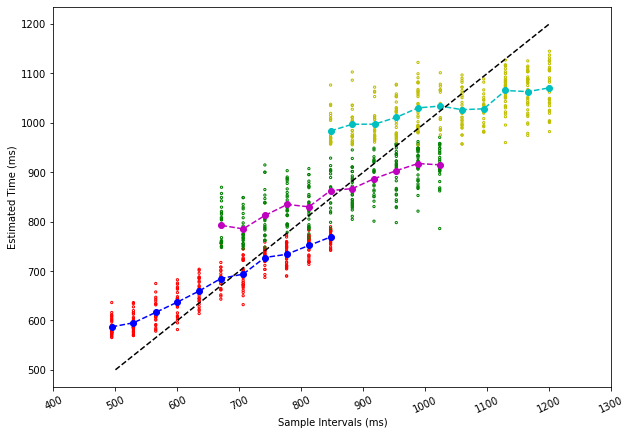

In [18]:
plt.figure(figsize=(10,7))
plt.xlim(400, 1300)
#plt.plot(xs,ys,'ro', markersize=4)
plt.scatter(xs,ys, facecolors='none', edgecolors='r', s = 5)
plt.plot(xs_,ys_, linestyle = 'dashed', marker = 'o', color = 'b', markersize=6)

plt.scatter(xm,ym, facecolors='none', edgecolors='g', s = 5)
plt.plot(xm_,ym_,linestyle = 'dashed', marker = 'o', color = 'm', markersize=6)

plt.scatter(xl,yl, facecolors='none', edgecolors='y', s = 5)
plt.plot(xl_,yl_,linestyle = 'dashed', marker = 'o', color = 'c', markersize=6)

t = np.linspace(500, 1200, 1000)
plt.plot(t, t, 'k', linestyle = 'dashed')
plt.xticks(rotation = 25)
plt.xlabel('Sample Intervals (ms)')
plt.ylabel('Estimated Time (ms)')